#SKIN CANCER DETECTION

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



#### The dataset has 8 types of diseases. These are :-
  - actinic keratosis
  - basal cell carcinoma
  - dermatofibroma
  - melanoma
  - nevus
  - pigmented benign keratosis
  - seborrheic keratosis
  - squamous cell carcinoma
  - vascular lesion

In [70]:
#Importing the packages
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import random
import os
import PIL
import Augmentor
from glob import  glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Uploading the data

In [27]:
#We will now mount the data on google collab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [29]:
#Path for train
data_dir_train

PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [30]:
#Path for test
data_dir_test

PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [31]:
#Checking the size of test and train data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images in train data are: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images in test data are: ", image_count_test)

Number of images in train data are:  2239
Number of images in test data are:  118


# Creating the dataset for analysis

Define some parameters for the loader:

In [32]:
batch_size = 32
img_height = 180
img_width = 180

### Test Dataset

In [33]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size= (img_height, img_width),
  batch_size= batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### Validation Dataset

In [34]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size= (img_height, img_width),
  batch_size= batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [35]:
### Classes for Dataset
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [36]:
#Another parameter for the analysis would now be the number of classes
class_numb = len(class_names)
class_numb

9

### Exploratory data analysis

#### Visualizing the data

Looking at the train dataset

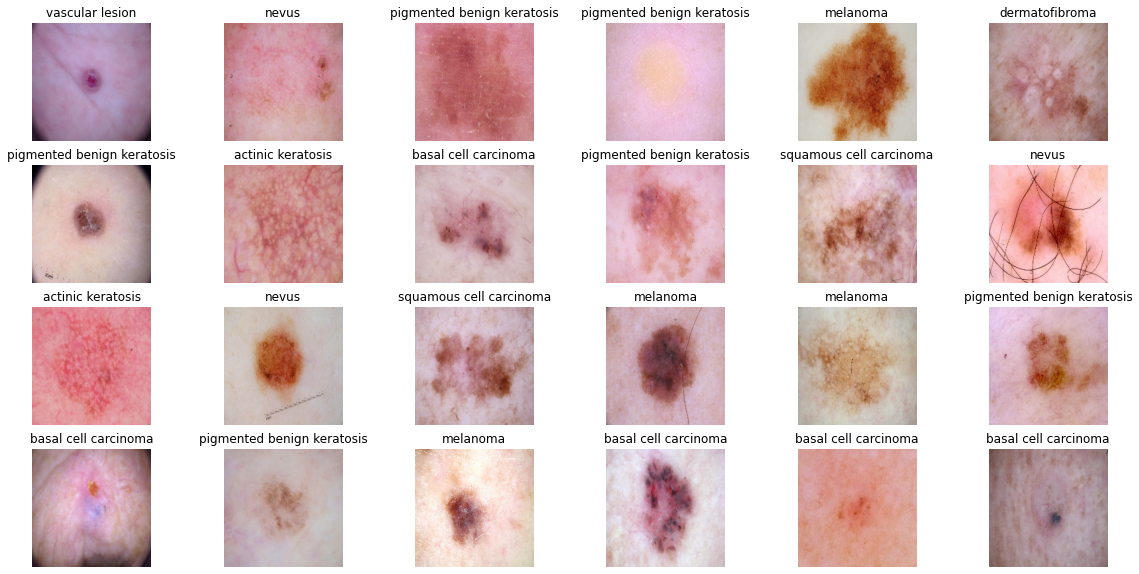

In [37]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Looking at the validation dataset

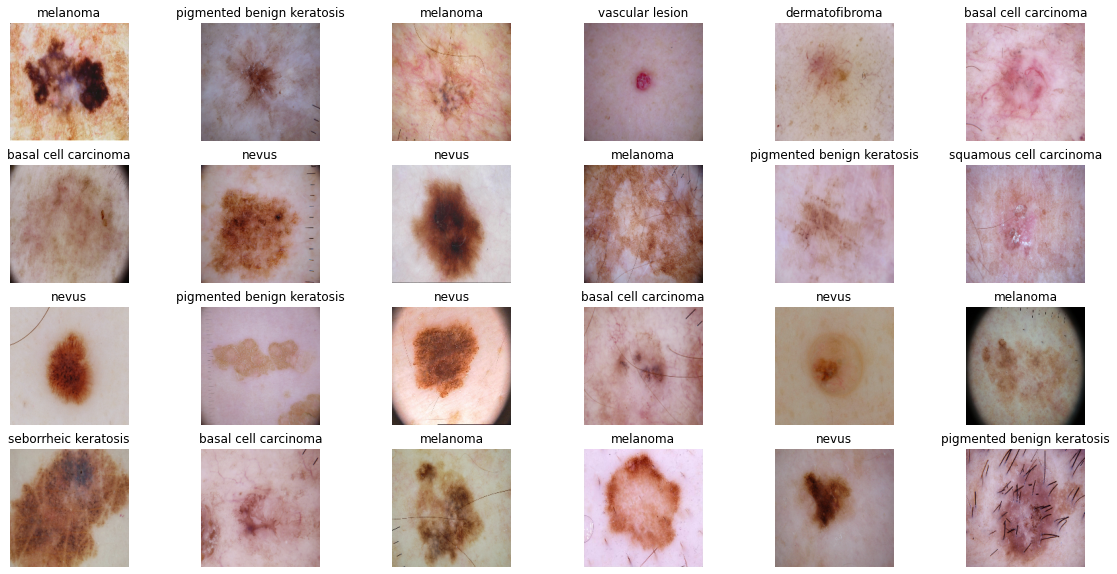

In [38]:
plt.figure(figsize=(20, 10))
for images, labels in val_ds.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

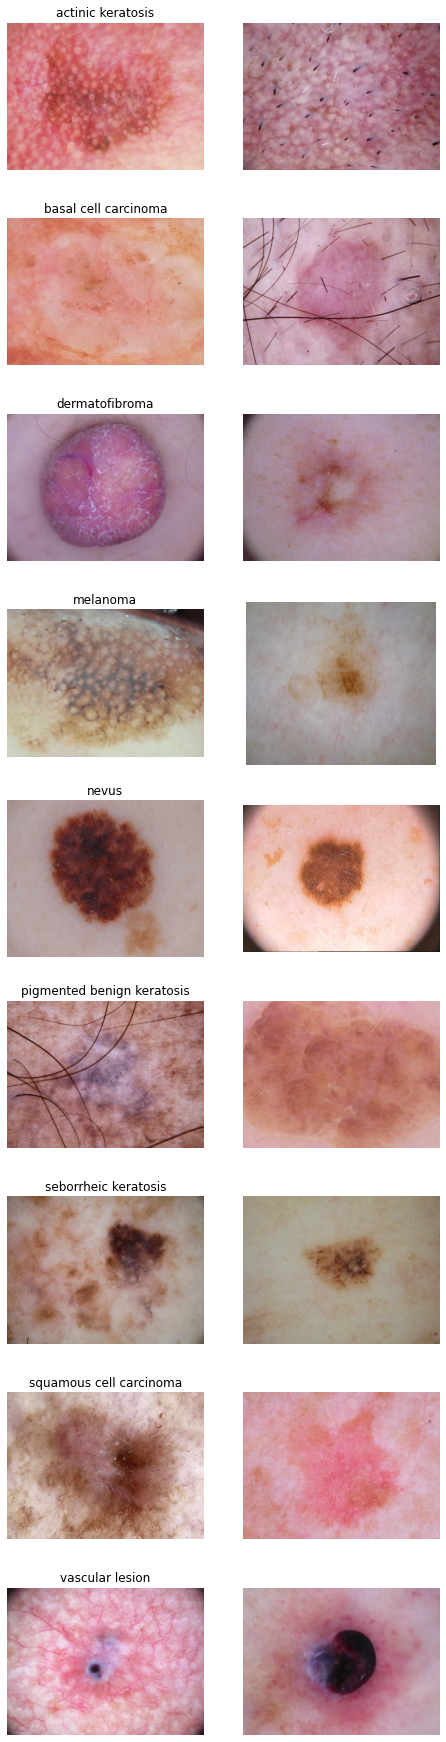

In [39]:
#Looking at all the 2 samples of each of the disease from the training dataset

plt.figure(figsize= (30, 30))

for n, class_name in enumerate(class_names):
    class_path = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/"+class_name)
    
    path_list = [x for x in class_path.glob('*')]
    
    for i in range(2):
        ax = plt.subplot(9,2,2*n+i+1)
        m = random.randint(0, len(path_list)-1)
        image = mpimg.imread(path_list[m])
        plt.imshow(image)
        if i % 2 == 0:
            plt.title(class_name)
        plt.axis('off')
        plt.subplots_adjust(left=0.3, bottom=0.1, right=0.5, top=0.9, wspace=0.2, hspace=0.2)
  

*The* `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the dataset

We need to create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

## MODEL 1

In [49]:
### Your code goes here
num_classes = 9

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    layers.Conv2D(16,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)
])

In [50]:
# Choosing an appropriate optimiser and loss function for model training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

### Training the model

In [52]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 24ms/step - loss: 2.0936 - accuracy: 0.2427 - val_loss: 1.9236 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8275 - accuracy: 0.3410 - val_loss: 1.6622 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5586 - accuracy: 0.4453 - val_loss: 1.5310 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4093 - accuracy: 0.5134 - val_loss: 1.3934 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3252 - accuracy: 0.5329 - val_loss: 1.5843 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3112 - accuracy: 0.5318 - val_loss: 1.3851 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1452 - accuracy: 0.5893 - val_loss: 1.3817 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing training results

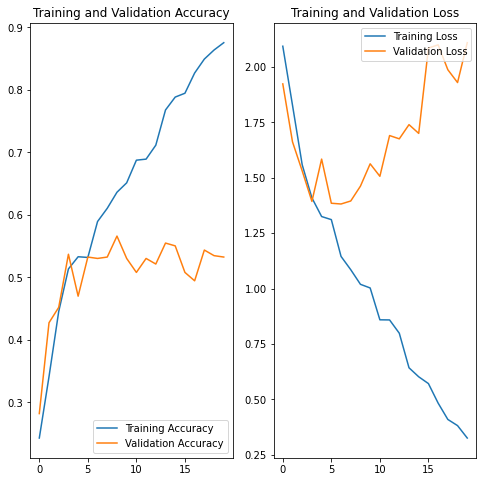

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings :-
 - The training data accuracy is much more that the validation data accuracy which is a clear sign of overfitting.
 - Initially there wasn't much difference between the test and validation accuracy.

### Augmentation Strategy in case of Overfitting model

In [54]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (img_height, img_width,3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

### Visualizing the Augmentation strategy

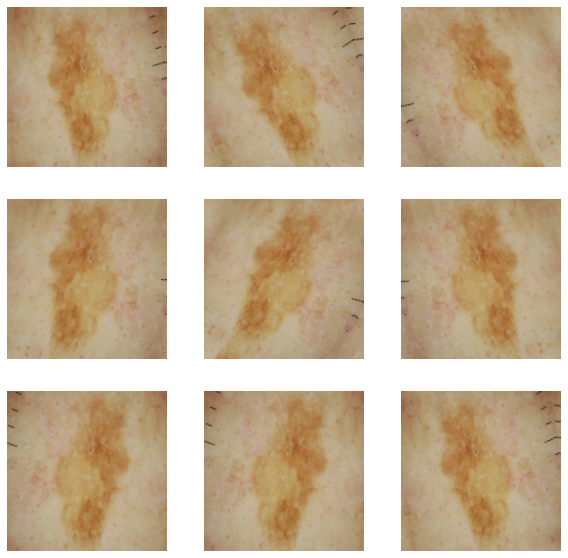

In [55]:
plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis("off");

## MODEL 2

As there seems to be overfittingin the model, we are going to dropout layer

In [57]:
model = Sequential([
                    data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)
])

In [58]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
#Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 2.0680 - accuracy: 0.2344 - val_loss: 1.8655 - val_accuracy: 0.3087
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7461 - accuracy: 0.3471 - val_loss: 1.6378 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6007 - accuracy: 0.4252 - val_loss: 1.5370 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5009 - accuracy: 0.4621 - val_loss: 1.5622 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4275 - accuracy: 0.4883 - val_loss: 1.4451 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3941 - accuracy: 0.5084 - val_loss: 1.4859 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3133 - accuracy: 0.5324 - val_loss: 1.3741 - val_accuracy: 0.5414
Epoch 8/20
56

### Visualizing the results

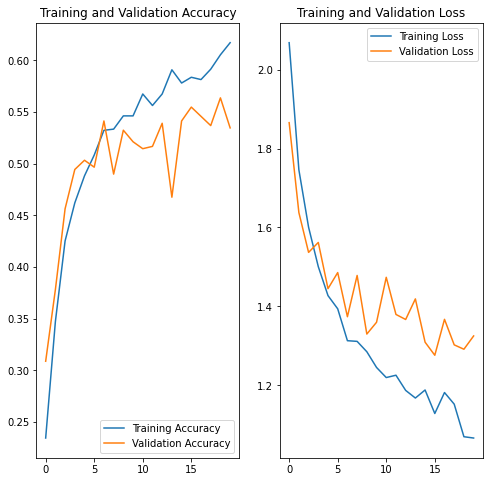

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings :-
- It can be seen that the training accuracy and validation accuracy are almost similar now.
- The problem of overfitting has been solved.
- But both the accuracy as very low and the model is a dumb model.
- There must be some problem is the preprocessing of the data. Let's check the class distribution of the data.

### Class Distribution of training dataset

In [64]:
path_list = [ x for x in glob(os.path.join(data_dir_train, "*", "*.jpg")) ]

In [81]:
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, "*", "*.jpg")) ]
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()), columns= ['Path', 'Label'])
original_df['Label'].value_counts(normalize = True)*100

pigmented benign keratosis    20.634212
melanoma                      19.562305
basal cell carcinoma          16.793211
nevus                         15.944618
squamous cell carcinoma        8.083966
vascular lesion                6.208129
actinic keratosis              5.091559
dermatofibroma                 4.242966
seborrheic keratosis           3.439035
Name: Label, dtype: float64

In [82]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

- We can see a clear imbalance in the data as Pigmented Keratosis, Melanoma, Carcinoma and nevus account for 70% of the data and only 30% of the data is for the rest of the classes. 
The rest of the classes are very low in number.
- Seborrheic Keratosis has the lowest number.


To handle the class imbalance, 
We are adding 500 samples per class to make sure that none of the classes are sparse.

In [72]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3D0809E4D0>: 100%|██████████| 500/500 [00:15<00:00, 32.27 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3D2C579A10>: 100%|██████████| 500/500 [00:15<00:00, 32.23 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3D0809E610>: 100%|██████████| 500/500 [00:16<00:00, 31.20 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F3D25887950>: 100%|██████████| 500/500 [01:18<00:00,  6.34 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3D08060AD0>: 100%|██████████| 500/500 [01:23<00:00,  6.01 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3D0807C910>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3D24E5AC50>: 100%|██████████| 500/500 [00:16<00:00, 30.77 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3D2C564B10>: 100%|██████████| 500/500 [00:40<00:00, 12.38 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3D08095DD0>:   0%|          | 1/500 [00:00<00:54,  9.12 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3D2C5EDE90>: 100%|██████████| 500/500 [00:15<00:00, 31.79 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3D2C564490>:   0%|          | 1/500 [00:00<00:50,  9.83 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3D2C488710>: 100%|██████████| 500/500 [00:16<00:00, 31.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [73]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [75]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [83]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [84]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [85]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating validation dataset

In [86]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## MODEL 3

In [91]:
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3, padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Dropout(0.3),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)
])

In [92]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [93]:
#Training the model
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 26s 149ms/step - loss: 1.7821 - accuracy: 0.3264 - val_loss: 1.5143 - val_accuracy: 0.4313
Epoch 2/30
169/169 [==============================] - 26s 149ms/step - loss: 1.4399 - accuracy: 0.4700 - val_loss: 1.3148 - val_accuracy: 0.5071
Epoch 3/30
169/169 [==============================] - 26s 148ms/step - loss: 1.2309 - accuracy: 0.5421 - val_loss: 1.1707 - val_accuracy: 0.5627
Epoch 4/30
169/169 [==============================] - 26s 148ms/step - loss: 1.0761 - accuracy: 0.5987 - val_loss: 1.0844 - val_accuracy: 0.5902
Epoch 5/30
169/169 [==============================] - 26s 148ms/step - loss: 0.9447 - accuracy: 0.6528 - val_loss: 0.9506 - val_accuracy: 0.6333
Epoch 6/30
169/169 [==============================] - 26s 148ms/step - loss: 0.8092 - accuracy: 0.7003 - val_loss: 0.9701 - val_accuracy: 0.6399
Epoch 7/30
169/169 [==============================] - 26s 147ms/step - loss: 0.6997 - accuracy: 0.7424 - val_loss: 0.8993 - val_ac

## Visualizing the model

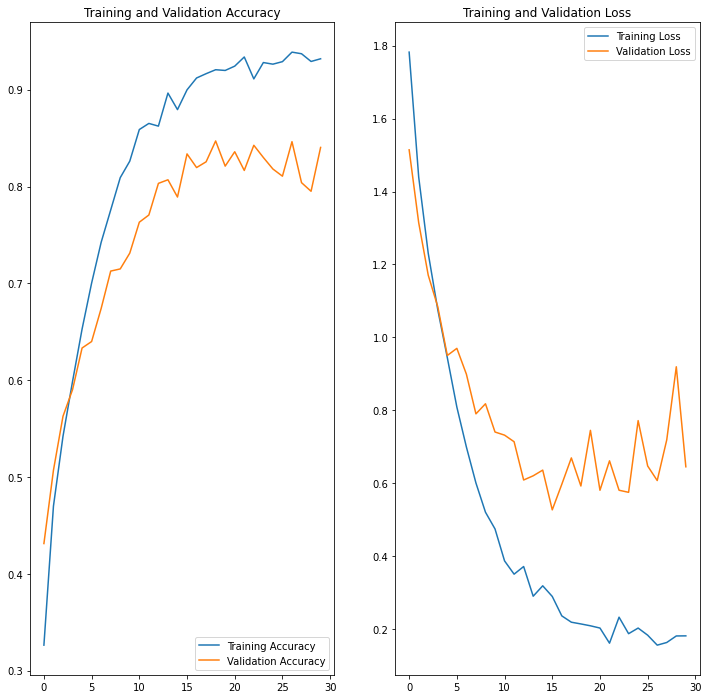

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion :-
- Both the training and validation are now close to each other as a result of augmentation there is no overfitting.
- Training data and validation data have accuracy near 90% and 84% respectively which a high enough value. Hence the model is decent.

Augmentation and Data Balancing have worked effectively on making our final model good.
